ABT-3 <br>
Выполнила: Голикова Софья

1. [Предварительный анализ](#preliminary_analysis)
2. Исследование метрик
    1. [Среднее значение metric_value](#metric_value)
    2. [Среднее количество сессий](#sessions_num)
    3. [Доля churn_users в рамках групп](#churn_ratio)
4. [Общий вывод](#conclusion)

<a name="preliminary_analysis"></a>
#Предварительный анализ

На сайте проводится эксперимент. Время проведения эксперимента
– 2 недели. <br>
Всего на сайте DAU около 500 000 и WAU около 850 000. Всего за
время работы на сайте образовалась аудитория из около 1 500 000 не
уходящих в отток посетителей. <br>
Необходимо по имеющимся данным исследовать, какие позитивные и негативные эффекты вызвало нововведение. 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from seaborn_qqplot import pplot
from scipy.stats import norm

from bootstrapped import bootstrap as bs
from bootstrapped import compare_functions as bs_compare
from bootstrapped import stats_functions as bs_stats

In [ ]:
buckets = pd.read_csv('gdrive/MyDrive/Colab Notebooks/abt2_data/hw_abt_2_bybucket.csv', 
                      delimiter='\t')
users = pd.read_csv('gdrive/MyDrive/Colab Notebooks/abt2_data/hw_abt_2_byuser.csv', 
                    delimiter='\t', index_col=0)

Колонки в таблицах:
- group_id - bucket’ы с номерами от 1 до 16. К группе ‘A’, контрольной, относятся bucket’ы 1..8, к группе ‘B’, экспериментальной, – 9..16;
- metric_value – сумма целевых действий пользователей в рамках bucket’а –
например, просмотров рекламного баннера, телефона на сайте classified-сервиса
или покупок в retail/FMCG;
- users – кол-во пользователей, совершивших целевое действие;
- visits – кол-во целевых сессий (закончившихся успешным целевым действием);
- churn_users – кол-во пользователей в рамках bucket’а, отказавшихся
сделать заказ или ушедших в отток во время эксперимента;
- churn_visits – количество сессий, не закончившихся успешным целевым действием.

In [ ]:
buckets

,group_id,metric_value,users,visits,churn_users,churn_visits
0,1,1875345.000,155,1419,151,2207
1,2,1662237.000,138,1320,127,1853
2,3,1784372.000,128,1281,159,2032
3,4,1876826.000,163,1644,168,2172
4,5,1913180.000,156,1675,174,2273
5,6,1733079.000,144,1509,141,2009
6,7,1864555.000,151,1481,161,2139
7,8,2029143.000,162,1533,153,2299
8,9,2047289.536,143,1424,242,2191
9,10,2228154.648,179,1803,265,2518


In [ ]:
users.head(10)

,group_id,metric_value,users,visits,churn_users,churn_visits,group
0,8,6630.000,0,0,0,8,A
1,13,6933.976,0,0,1,6,B
2,10,8261.976,1,10,1,8,B
3,4,5522.000,1,9,1,7,A
4,16,5075.976,1,6,0,8,B
5,2,8539.000,0,0,0,8,A
6,8,5714.000,0,0,0,7,A
7,3,7330.000,0,0,0,6,A
8,2,6759.000,1,4,1,7,A
9,12,6963.976,1,1,0,6,B


В таблице пользователей сразу бросается в глаза ситуация, когда visits = 0, а metric_value > 0. То есть, у этих пользователей не было успешных целевых сессий, однако metric_value для них не равно 0. Несколько предположений по этому поводу мы рассмотрели в ABT-2, и в итоге остановились на версии "успешность сессии может определяться последним действием пользователя, тогда пользователь за одну и ту же сессию может сначала совершить целевое действие (сделать заказ), а потом отказаться от выполнения целевого действия (отменить другой созданный заказ)".

Также поясним некоторые не совсем очевидные моменты (на основе наших предположений и допущений): <br>
- visits = 0, users != 0 - пользователь только создал аккаунт либо перекрыл успешное действие неуспешным во время сессии 
- churn_visits = 0, churn_users != 0 - пользователь удалил аккаунт сразу после создания (в той же сессии)
- churn_visits != 0, churn_users = 0 - пользователь не ушел в отток, но периодически совершает неудачные действия

Размеры выборок:

In [ ]:
print('Group A size: {}'.format(users.loc[users['group'] == 'A'].shape[0]))
print('Group B size: {}'.format(users.loc[users['group'] == 'B'].shape[0]))
print('Size ratio: {}'.format(users.loc[users['group'] == 'A'].shape[0] / 
                              users.loc[users['group'] == 'B'].shape[0]))

Group A size: 2451
Group B size: 2549
Size ratio: 0.9615535504119262


Метрики, которые мы будем исследовать при сравнении групп A и B:
1. Среднее значение metric_value
2. Среднее количество сессий (и удачных, и неудачных)
3. Доля churn_users (ratio-метрика) в рамках групп

<a name="metric_value"></a>
#Среднее значение metric_value

**Нулевая гипотеза**: <br>
H0 - раличия в средних значениях metric_value для групп A и B вызваны лишь случайными причинами <br>
**Альтернативная гипотеза**: <br>
H1 -  между средними значениями metric_value для групп A и B действительно существуют значимые различия

In [ ]:
metric_group_a = users.loc[users['group'] == 'A']['metric_value']
metric_group_b = users.loc[users['group'] == 'B']['metric_value']

In [ ]:
metric_mean_a = metric_group_a.mean()
metric_mean_b = metric_group_b.mean()

print('Group A Metric Value mean: ', metric_mean_a, sep='')
print('Group B Metric Value mean: ', metric_mean_b, sep='')

Group A Metric Value mean: 6013.356589147287
Group B Metric Value mean: 6446.181178501194


In [ ]:
lift = (metric_mean_b - metric_mean_a) / metric_mean_a * 100
print('Lift: {:.2}%'.format(lift))

Lift: 7.2%


Распределения metric_value для каждой из групп:

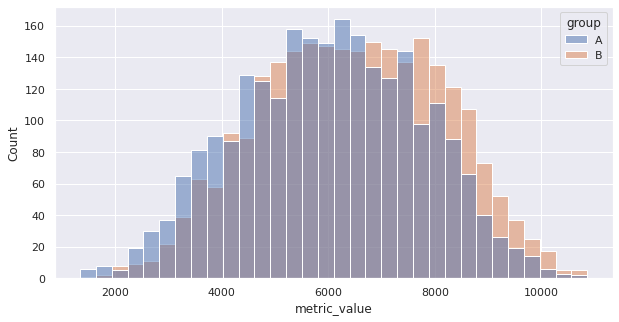

In [ ]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10, 5)})

sns.histplot(data=users, x="metric_value", hue='group')
plt.show()

Диаграммы размаха:

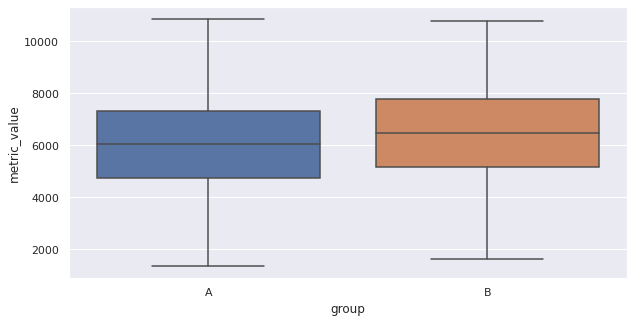

In [ ]:
sns.set(rc={'figure.figsize':(10, 5)})

sns.boxplot(x='group', y='metric_value', data=users)
plt.show()

###Проверка распределений на нормальность

**H0**: распределение является нормальным <br>
**H1**: распределение не является нормальным

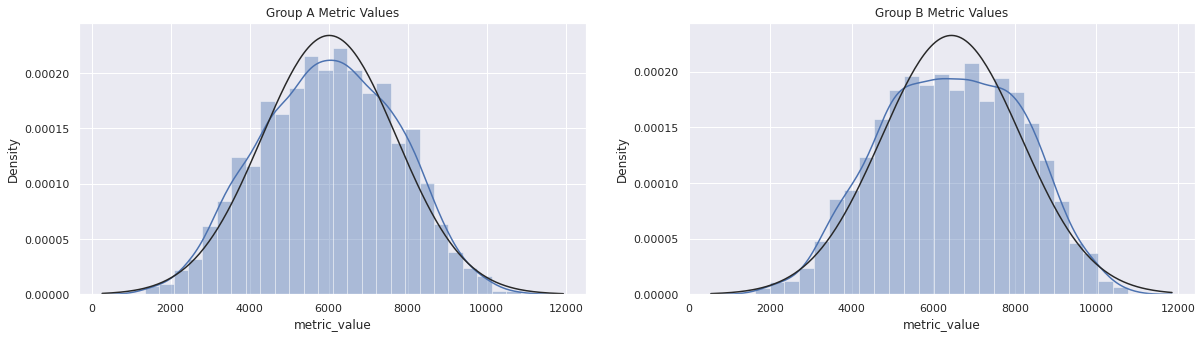

In [ ]:
sns.set(rc={'figure.figsize':(20, 5)})
fig, ax = plt.subplots(1, 2)

sns.distplot(metric_group_a, fit=norm, ax=ax[0])
ax[0].set_title('Group A Metric Values')
sns.distplot(metric_group_b, fit=norm, ax=ax[1])
ax[1].set_title('Group B Metric Values')

fig.show()

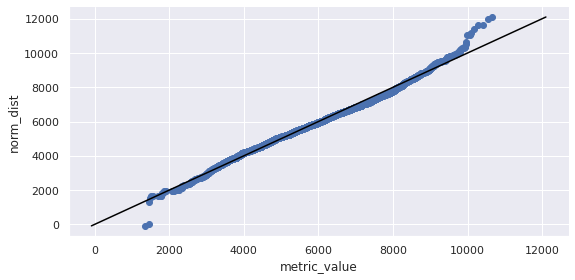

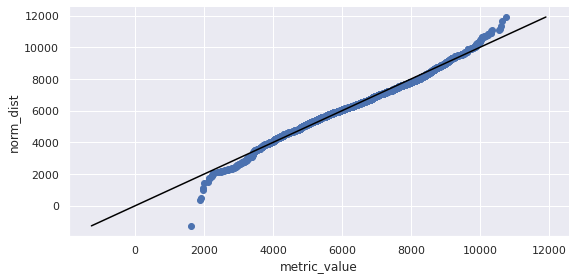

In [ ]:
sns.set(rc={'figure.figsize':(10, 5)})

tmp_a = pd.DataFrame(metric_group_a)
pplot(tmp_a, x='metric_value', y=norm, kind='qq', height=4, aspect=2, 
      display_kws={'identity':True})

tmp_b = pd.DataFrame(metric_group_b)
pplot(tmp_b, x='metric_value', y=norm, kind='qq', height=4, aspect=2, 
      display_kws={'identity':True})

plt.show()

Визуально распределения напоминают нормальные, но с отклонениями.<br>
Проведем формальный тест, чтобы проверить нормальность распределений.

Воспользуемся критерием Шапиро-Уилка для проверки распределений на нормальность. <br>
Используем данный критерий, т.к. нам необходимо проверить соответствие закона распределения именно нормальному, а свойства данного критерия обладают большей мощностью перед широким выбором альтернативных критериев согласия. 

In [ ]:
from scipy.stats import shapiro

alpha = 0.05

p_value = shapiro(metric_group_a)[1]

print('Distribution A is {}normal (p-value = {:.2})'.
      format({True:'not ', False:''}[p_value < alpha], 
             p_value))

p_value = shapiro(metric_group_b)[1]

print('Distribution B is {}normal (p-value = {:.2})'.
      format({True:'not ', False:''}[p_value < alpha], p_value))

Distribution A is not normal (p-value = 3.5e-07)
Distribution B is not normal (p-value = 2.5e-10)


Мы ошиблись с нашей визуальной оценкой: p-value получилось намного меньше заданного уровня значимости, а значит, мы **отвергаем нулевую гипотезу H0**, утверждающую, что распределение значений metric_value является нормальным (как для группы A, так и для группы B).

###Проверка равенства дисперсий

**H0**: Var(X1) = Var(X2) <br>
**H1**: Var(X1) != Var(X2)

В качестве критерия однородности используем критерий Левена, т.к. он менее чувствителен к отклонению распределения от нормального, чем другие критерии однородности (такие как F-критерий Фишера или критерий Бартлетта).

In [ ]:
from scipy.stats import levene
 
alpha = 0.05 

p_value = levene(metric_group_a, metric_group_b)[1] 

print('{} the H0: Var(X1) = Var(X2) (p-value = {:.2})\n'.
      format({True:'Reject', False:'Confirm'}[p_value < alpha], p_value))

Confirm the H0: Var(X1) = Var(X2) (p-value = 0.35)



На основании полученного значения p-value мы **не можем отвергнуть нулевую гипотезу H0** о равенстве дисперсий групп A и B.

###Проверка статистической значимости различий 

Воспользуемся методом bootstrap для проверки статистической значимости различий

In [ ]:
metric_bs = bs.bootstrap_ab(np.array(metric_group_b), np.array(metric_group_a), 
                            bs_stats.mean,
                            bs_compare.percent_change, 
                            num_iterations=5000, iteration_batch_size=100, 
                            alpha=0.05,
                            scale_test_by=1, num_threads=4)

metric_bs

7.197720323707961    (5.5661004440145465, 8.83936492989364)

Получили, что 95-процентный доверительный интервал не содержит 0, а значит, мы можем **отвергнуть H0**.<br><br>
То есть различия между средними значениями metric_value для групп A и B статистически значимы. Средняя сумма целевых действий пользователей в экспериментальной группе больше по сравнению с контрольной, следовательно, **нововведение имело положительный эффект в плане увеличения среднего показателя metric_value**.

<a name="sessions_num"></a>
#Среднее количество сессий

Берем общее количество сессий для данной метрики, так как, в соответствии с нашим предположением, определить "чистое" количество успешных и неуспешных сессий (в которых неудачное действие не перекрывало бы удачное) достаточно трудно

**Нулевая гипотеза**: <br>
H0 - различия в средних количествах сессий для групп A и B вызваны лишь случайными причинами <br>
**Альтернативная гипотеза**: <br>
H1 -  между средними количествами сессий для групп A и B действительно существуют значимые различия

Создадим в таблице дополнительную колонку с общим количеством сессий для каждого пользователя:

In [ ]:
users['total_visits'] = users['churn_visits'] + users['visits']
users.head()

,group_id,metric_value,users,visits,churn_users,churn_visits,group,total_visits
0,8,6630.000,0,0,0,8,A,8
1,13,6933.976,0,0,1,6,B,6
2,10,8261.976,1,10,1,8,B,18
3,4,5522.000,1,9,1,7,A,16
4,16,5075.976,1,6,0,8,B,14


In [ ]:
visits_group_a = users.loc[users['group'] == 'A']['total_visits']
visits_group_b = users.loc[users['group'] == 'B']['total_visits']

In [ ]:
print('Group A Total Visits mean: ', visits_group_a.mean(), sep='')
print('Group B Total Visits mean: ', visits_group_b.mean(), sep='')

Group A Total Visits mean: 11.76907384740922
Group B Total Visits mean: 11.53432718713221


In [ ]:
lift = (visits_group_b.mean() - visits_group_a.mean()) / visits_group_b.mean() * 100
print('Lift: {:.2}%'.format(lift))

Lift: -2.0%


Распределения total_visits для каждой из групп:

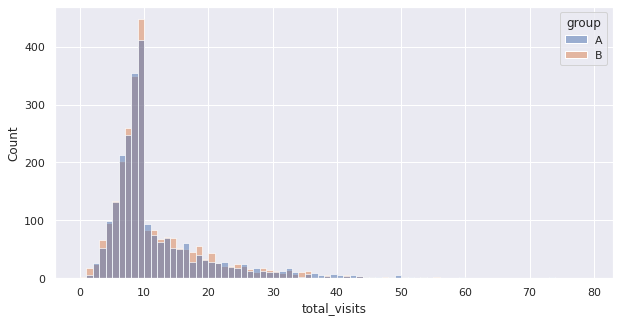

In [ ]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10, 5)})

sns.histplot(data=users, x='total_visits', hue='group', binwidth=1)
plt.show()

Распределения имеют длинный правый хвост. Это видно и на диаграммах размаха:

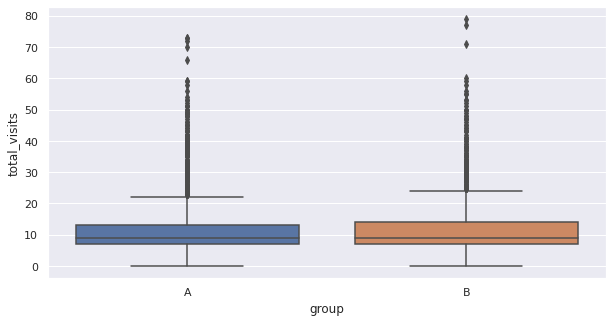

In [ ]:
sns.set(rc={'figure.figsize':(10, 5)})

sns.boxplot(x='group', y='total_visits', data=users)
plt.show()

Сформируем подвыборки из наших выборок с помощью метода bootstrap

In [ ]:
visits_bs_a = bs.bootstrap(np.array(visits_group_a),
                           stat_func=bs_stats.mean, num_iterations=10000,
                           iteration_batch_size=100,
                           return_distribution=True)
visits_bs_b = bs.bootstrap(np.array(visits_group_b),
                           stat_func=bs_stats.mean, num_iterations=10000,
                           iteration_batch_size=100,
                           return_distribution=True)

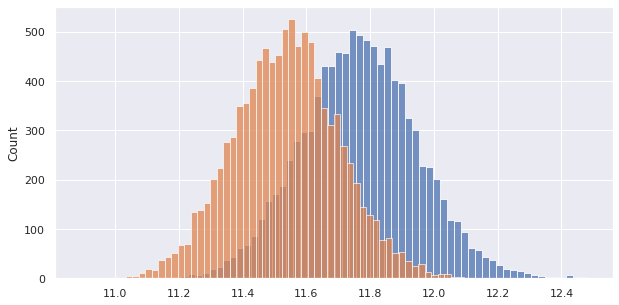

In [ ]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10, 5)})

sns.histplot(data=visits_bs_a)
sns.histplot(data=visits_bs_b, color='#de8551')
plt.show()

Как и ожидалось, длинный правый хвост исчез. Новые распределения, полученные с помощью метода bootstrap, стали близки к нормальным. Для полученных распределений теперь можно использовать T-тест, но в данной работе мы будем использовать bootstrap для построения доверительного интервала и проверки статистической значимости различий на его основе

###Проверка распределений на нормальность

*Проверяем исходные выборки: visits_group_a и visits_group_b

**H0**: распределение является нормальным <br>
**H1**: распределение не является нормальным

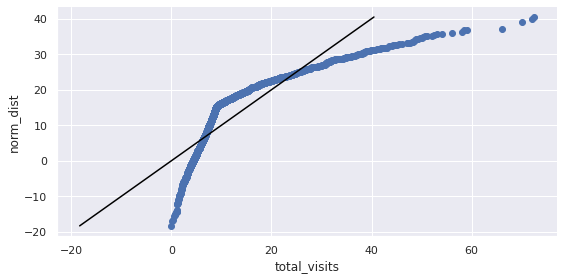

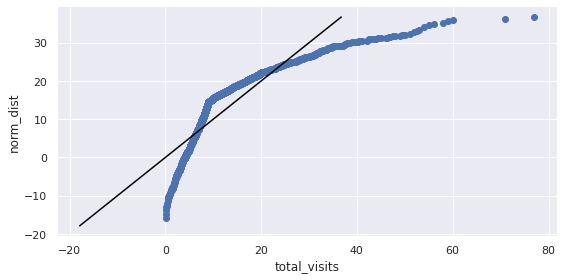

In [ ]:
tmp_a = pd.DataFrame(visits_group_a)
pplot(tmp_a, x='total_visits', y=norm, kind='qq', height=4, aspect=2, display_kws={'identity':True})

tmp_b = pd.DataFrame(visits_group_b)
pplot(tmp_b, x='total_visits', y=norm, kind='qq', height=4, aspect=2, display_kws={'identity':True})

plt.show()

Как мы указали выше, у распределений есть длинный правый хвост, что делает их совсем не похожими на нормальные. Однако в любом случае проведем формальный тест.

Воспользуемся критерием Шапиро-Уилка для проверки распределений на нормальность. 

In [ ]:
from scipy.stats import shapiro

alpha = 0.05

p_value = shapiro(visits_group_a)[1]

print('Distribution A is {}normal (p-value = {})'.
      format({True:'not ', False:''}[p_value < alpha], 
             p_value))

p_value = shapiro(visits_group_b)[1]

print('Distribution B is {}normal (p-value = {})'.
      format({True:'not ', False:''}[p_value < alpha],
             p_value))

Distribution A is not normal (p-value = 0.0)
Distribution B is not normal (p-value = 0.0)


Наши предположения оказались верны: **отвергаем нулевую гипотезу H0**, утверждающую, что распределение значений total_visits является нормальным (как для группы A, так и для группы B).

###Проверка равенства дисперсий

**H0**: Var(X1) = Var(X2) <br>
**H1**: Var(X1) != Var(X2)

В качестве критерия однородности используем критерий Левена, т.к. он менее чувствителен к отклонению распределения от нормального, чем другие критерии однородности (такие как F-критерий Фишера и критерий Бартлетта).

In [ ]:
from scipy.stats import levene
 
alpha = 0.05 

p_value = levene(visits_group_a, visits_group_b)[1]

print('{} the H0: Var(X1) = Var(X2) (p-value = {})\n'.
      format({True:'Reject', False:'Confirm'}[p_value < alpha],
             p_value))

Confirm the H0: Var(X1) = Var(X2) (p-value = 0.29144064110820345)



На основании полученного значения p-value мы **не можем отвергнуть нулевую гипотезу H0** о равенстве дисперсий групп A и B.

###Проверка статистической значимости различий 

Воспользуемся методом bootstrap для проверки статистической значимости различий

In [ ]:
visits_bs = bs.bootstrap_ab(np.array(visits_group_b), np.array(visits_group_a), 
                            bs_stats.mean,
                            bs_compare.percent_change, num_iterations=5000, 
                            alpha=0.05, iteration_batch_size=100, 
                            scale_test_by=1, num_threads=4)

visits_bs

-1.9946060609407004    (-5.494843950001991, 1.3802416239233746)

Получили, что 95-процентный доверительный интервал содержит 0, а значит, мы **не можем отвергнуть H0**.

То есть различия различия в средних количествах сессий для групп A и B вызваны лишь случайными причинами и статистически не значимы. **Нововведение не оказало существенного влияния на среднее количество сессий пользователей.**

<a name="churn_ratio"></a>
#Доля churn_users в рамках групп

**Нулевая гипотеза**: <br>
H0 - различия в долях ушедших пользователей для групп A и B вызваны лишь случайными причинами <br>
**Альтернативная гипотеза**: <br>
H1 -  между долями ушедших пользователей для групп A и B действительно существуют значимые различия

Создадим в таблице дополнительную колонку с долей churn_users для каждой группы. Также добавим колонку 'group' с названием группы (A или B) для удобства:

In [ ]:
buckets['churn_ratio'] = (buckets['churn_users'] / 
                          (buckets['users'] + buckets['churn_users']))

buckets.loc[buckets['group_id'] <= 8, 'group'] = 'A'
buckets.loc[buckets['group_id'] > 8, 'group'] = 'B'

buckets

,group_id,metric_value,users,visits,churn_users,churn_visits,churn_ratio,group
0,1,1875345.000,155,1419,151,2207,0.493464,A
1,2,1662237.000,138,1320,127,1853,0.479245,A
2,3,1784372.000,128,1281,159,2032,0.554007,A
3,4,1876826.000,163,1644,168,2172,0.507553,A
4,5,1913180.000,156,1675,174,2273,0.527273,A
5,6,1733079.000,144,1509,141,2009,0.494737,A
6,7,1864555.000,151,1481,161,2139,0.516026,A
7,8,2029143.000,162,1533,153,2299,0.485714,A
8,9,2047289.536,143,1424,242,2191,0.628571,B
9,10,2228154.648,179,1803,265,2518,0.596847,B


In [ ]:
churn_ratio_group_a = buckets.loc[buckets['group_id'] <= 8]['churn_ratio']
churn_ratio_group_b = buckets.loc[buckets['group_id'] > 8]['churn_ratio']

Распределения churn_ratio для каждой из групп:

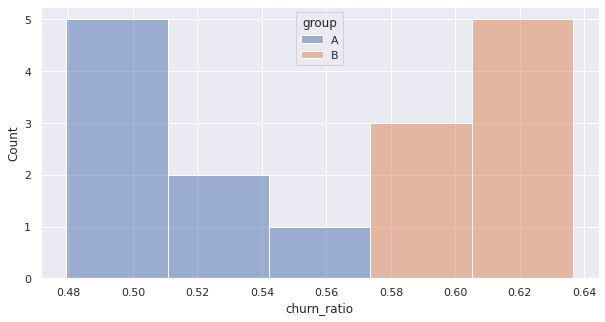

In [ ]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10, 5)})

sns.histplot(data=buckets, x="churn_ratio", hue='group')
plt.show()

Распределения выборок не являются нормальными, это может быть связано с их малыми размерами 

Диаграммы размаха:

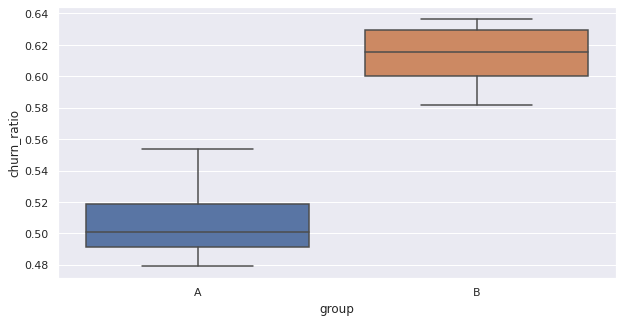

In [ ]:
sns.set(rc={'figure.figsize':(10, 5)})

sns.boxplot(x='group', y='churn_ratio', data=buckets)
plt.show()

Для ratio-метрик достаточно затруднительно использовать bootstrap, т.к. тогда бы пришлось учитывать и количество ушедших пользователей, и общее количество пользователей, и связь между ними<br><br>
Поэтому применим **дельта-метод** для проверки статистической значимости различий ratio-метрик с помощью построения доверительного интервала <br>
**Source**: Alex Deng, Ulf Knoblich and Jiannan Lu, Applying the Delta Method in Metric Analytics: A Practical Guide with Novel Ideas, 2018 https://arxiv.org/pdf/1803.06336.pdf<br>
![image.jpg](https://drive.google.com/uc?export=view&id=1myneu_AkIamZC_BbzVi5M_ZzkPf59C08)

In [ ]:
import scipy.stats as st

def delta_method_ratio(control, test, alpha = 0.05):

    n = 1/2 * (len(control) + len(test))
    c_mean = np.mean(control)
    t_mean = np.mean(test)
    c_var = np.var(control)
    t_var = np.var(test)
    c_t_covariance = np.cov(control, test)[0][1]

    pe = t_mean / c_mean - 1
    ve = ((t_var ** 2) / (c_mean ** 2) - 
          (2 * t_mean * c_t_covariance) / (c_mean ** 3) +
          (t_mean ** 2 * c_t_covariance) / (c_mean ** 4)) 
    
    z = st.norm.ppf(1 - alpha / 2)
    lower = pe - z * np.sqrt(ve / n)
    upper = pe + z * np.sqrt(ve / n)

    return pe, lower, upper

delta_method_ratio(churn_ratio_group_a, churn_ratio_group_b)

(0.20927279420083233, 0.1959134683860247, 0.22263212001563998)

Получили, что 95-процентный доверительный интервал не содержит 0, а значит, мы можем **отвергнуть H0**.<br><br>
То есть различия между долями ушедших пользователей для групп A и B статистически значимы. Процентное соотношение ушедших пользователей больше в тестовой группе, следовательно, **нововведение имело отрицательный эффект на отток пользователей: больше пользователей стало уходить**.

<a name="conclusion"></a>
#Общий вывод

Позитивный эффект нововведения: увеличение среднего показателя metric_value. <br>
Отрицательный эффект нововведения: больший отток пользователей.<br>
Не изменилось: среднее количество сессий пользователей.